In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

#So we have removed approximately 12 features
# Starting Gausian Mixture Model implementation
import matplotlib as mpl
import itertools
from sklearn import mixture
from scipy import linalg

DATA_DIR = "NSL_KDD_Dataset"
train_nsl_kdd_dataset_path = "KDDTrain+.txt"
test_nsl_kdd_dataset_path = "KDDTest+.txt"
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])
categoricalColumns = col_names[[1,2,3]]
binaryColumns = col_names[[6, 11, 13, 14, 20, 21]]
numericColumns = col_names[list(set(range(41)) - set([1,2,3]) - set([6, 11, 13, 14, 20, 21]))]

In [5]:
train = pd.read_csv(os.path.join(DATA_DIR, train_nsl_kdd_dataset_path), header=None)
train.drop([42], 1, inplace=True)
train.columns = col_names
train_shape = train.shape[0]
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:

test = pd.read_csv(os.path.join(DATA_DIR, test_nsl_kdd_dataset_path), header=None)
test.drop([42], 1, inplace=True)
test.columns = col_names
test_shape = test.shape[0]
print(test.shape)
test.head()

(22544, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [7]:
# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
   
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

In [8]:
mergedDataSet = pd.concat([train, test]).reset_index(drop=True)
# Performing all the encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc = LabelEncoder()
#
def encodeCategorical(ser):
    return enc.fit_transform(ser)

mergedDataSet['service'] = encodeCategorical(mergedDataSet['service'])
mergedDataSet['flag'] = encodeCategorical(mergedDataSet['flag'])
mergedDataSet = pd.get_dummies(mergedDataSet, columns=['protocol_type'])
mergedDataSet['labelsMapped'] = mergedDataSet['labels'].map(lambda x: attack_dict[x])

scaler = MinMaxScaler()
mergedDataSet[numericColumns] = scaler.fit_transform(mergedDataSet[numericColumns])

In [9]:
testDataSet = mergedDataSet.loc[train.shape[0]:,:]
trainDataSet = mergedDataSet.loc[:train.shape[0], :]

In [10]:
#binaryColumns = list(binaryColumns) + list(categoricalColumns[1:]) + [u'protocol_type_icmp', u'protocol_type_tcp', u'protocol_type_udp']
import sys
from collections import OrderedDict
e = sys.float_info.epsilon
def calAttributeRatio(df, numericColumns,binaryColumns):
    denom = {}
    ar = {}
    for col in numericColumns:
        denom[col] = df[col].mean();

    for col in numericColumns:
        ar[col] = df.fillna(value=0.0).groupby('labelsMapped')[[col]].mean().max().values[0]/(denom[col])

    def test_sum(series):
        return (series.sum()/(len(series)-series.sum()+e))
    for col in binaryColumns:
        groups = df.groupby('labelsMapped')[[col]]
        ar[col] = groups.aggregate([test_sum]).max().values[0]
    return ar

ar_op = calAttributeRatio(trainDataSet,numericColumns,binaryColumns)
#print(OrderedDict(sorted(ar_op.items(), key=lambda v: -v[1])))
def selectTopFeaturesByAR(ar_op, min_ar):
    return [c for c in ar_op.keys() if ar_op[c]>=min_ar]
selectedFeatures = selectTopFeaturesByAR(ar_op,1.00)
train_processed_selectedFeatures = pd.concat([trainDataSet[selectedFeatures], trainDataSet[['labelsMapped', u'protocol_type_icmp', u'protocol_type_tcp', u'protocol_type_udp', u'service', u'flag']]], axis=1)
train_processed_selectedFeatures.shape

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


(125974, 39)

In [11]:
#removing the unimportant columns  from test data set
test_processed_selectedFeatures = testDataSet[train_processed_selectedFeatures.columns]

In [15]:
from sklearn.cluster import KMeans


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
train_processed_selectedFeatures['binaryLabel'] = train_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
test_processed_selectedFeatures['binaryLabel'] = test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)

def kmeans_run(trainData, testData, clusters, failureLabel, toDrop):
    trainData = trainData.copy()
    kmeans_fin = KMeans(n_clusters=clusters, random_state=0).fit(trainData.drop(toDrop + [failureLabel], 1))
    labels_fin_test = kmeans_fin.predict(testData.drop(toDrop + [failureLabel], 1))
    labels_fin = kmeans_fin.predict(trainData.drop(toDrop + [failureLabel], 1))
    trainData['knn_l'] = labels_fin
    cluster_list = {}
    for i in range(clusters):
        lis = trainData[trainData['knn_l'] == i][failureLabel]
        cluster_list[i] = lis.mode()[0]
    pred_y = pd.Series(labels_fin_test).map(cluster_list)
    if trainData[failureLabel].unique().shape[0] != 2:
        precisionScore = precision_score(testData[failureLabel], pred_y, average = "weighted")
        recallScore = recall_score(testData[failureLabel], pred_y, average = "weighted")
    else:
        precisionScore = precision_score(testData[failureLabel], pred_y)
        recallScore = recall_score(testData[failureLabel], pred_y)
    return accuracy_score(testData[failureLabel], pred_y), precisionScore, recallScore ,pd.crosstab(testData[failureLabel].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True), kmeans_fin
    
    
num_clusters = 20
accuracy_l = {}
precision_l = {}
recall_l = {}

for k_val in range(1, num_clusters + 1):
    accuracy, precision, recall, conf_mat, kmeansMdl = kmeans_run(train_processed_selectedFeatures, test_processed_selectedFeatures, k_val, 'binaryLabel', ['labelsMapped'])
    #print "Accuracy:", accuracy, "Precision:", precision, "Recall:",  recall
    accuracy_l[k_val] = accuracy
    precision_l[k_val] = precision
    recall_l[k_val] = recall
    #print (conf_mat)
    
import operator
max(accuracy_l.iteritems(), key=operator.itemgetter(1))[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


20

In [18]:
import operator
max(accuracy_l.iteritems(), key=operator.itemgetter(1))[0]

20

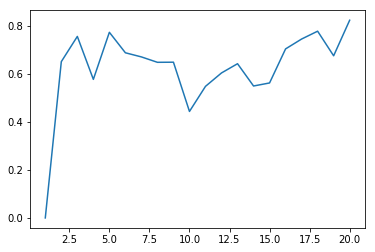

In [19]:
import matplotlib.pylab as plt

lists = sorted(recall_l.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

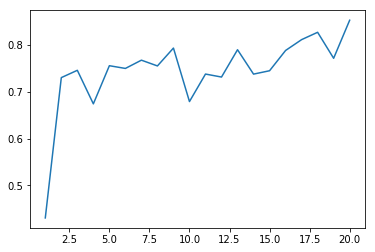

In [20]:
import matplotlib.pylab as plt

lists = sorted(accuracy_l.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

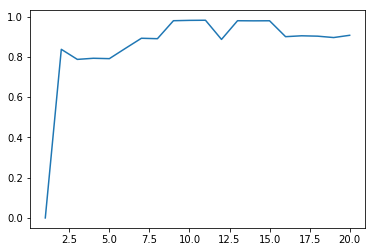

In [21]:
lists = sorted(precision_l.items())

x, y = zip(*lists)

plt.plot(x, y)
plt.show()

In [22]:
#Checking for a binary model
num_clusters = 9
accuracy, precision, recall, confMat, kmeansMdl = kmeans_run(train_processed_selectedFeatures, test_processed_selectedFeatures, num_clusters, 'binaryLabel', ['labelsMapped'])
print 'Binary Model accuracy is', accuracy, "Precision", precision, "Recall:",  recall
confMat

Binary Model accuracy is 0.792840349554 Precision 0.979668586203 Recall: 0.649575313645


Predicted,0,1,All
True,,,
0,9537,173,9710
1,4497,8336,12833
All,14034,8509,22543


In [23]:
#Checking for a binary model
num_clusters = 9
accuracy, precision, recall, confMat, kmeansMdl = kmeans_run(train_processed_selectedFeatures, test_processed_selectedFeatures, num_clusters, 'labelsMapped', ['binaryLabel'])
print 'Binary Model accuracy is', accuracy, "Precision", precision, "Recall:",  recall
confMat

Binary Model accuracy is 0.689837200018 Precision 0.526537671879 Recall: 0.689837200018


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,DoS,normal,All
True,,,
DoS,6014,1444,7458
Probe,1739,682,2421
R2L,432,2322,2754
U2R,151,49,200
normal,173,9537,9710
All,8509,14034,22543


In [16]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
#dbscan = DBSCAN(eps=3, algorithm = 'kd_tree', min_samples=5)    
#dbscan = DBSCAN(eps=4.5, algorithm = 'kd_tree',min_samples=5)    #- 750   
dbscan = DBSCAN(eps=1, algorithm = 'kd_tree',min_samples=4)    #- 500

# 2- 37 clulster - 0.07 Hom
# 1.75 , 5- 46 clulster - 0.6
# 1.75 , 3 - 65 clusters - 0.624
#print(data)
#'binaryLabel', 
labels_dbScan = dbscan.fit_predict(train_processed_selectedFeatures.drop(['labelsMapped'], 1).append(test_processed_selectedFeatures.drop(['labelsMapped'], 1)))

In [22]:
mergedDataSet = train_processed_selectedFeatures.append(test_processed_selectedFeatures)
toDrop = []
failureLabel = 'labelsMapped'
#labels_fin_test = dbscan.predict(testData.drop(toDrop + [failureLabel], 1))
#labels_fin = dbscan.predict(trainData.drop(toDrop + [failureLabel], 1))
#trainData['dbScan_l'] = labels_fin
cluster_list = {}
for i in np.unique(labels_dbScan):
    lis = mergedDataSet[labels_dbScan == i][failureLabel]
    cluster_list[i] = lis.mode()[0]
pred_y = pd.Series(labels_dbScan).map(cluster_list)
if mergedDataSet[failureLabel].unique().shape[0] != 2:
    precisionScore = precision_score(mergedDataSet[failureLabel], pred_y, average = "weighted")
    recallScore = recall_score(mergedDataSet[failureLabel], pred_y, average = "weighted")
else:
    precisionScore = precision_score(mergedDataSet[failureLabel], pred_y)
    recallScore = recall_score(mergedDataSet[failureLabel], pred_y)
print accuracy_score(mergedDataSet[failureLabel], pred_y)
print precisionScore, recallScore 
print pd.crosstab(mergedDataSet[failureLabel].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True)

0.917605946754
0.917180486234 0.917605946754
Predicted    DoS  Probe   R2L  U2R  normal     All
True                                              
DoS        50375     35     0    0    2976   53386
Probe       2778   9237     2    0    2060   14077
R2L          421     32   854    0    2442    3749
U2R            2      6     0  112     132     252
normal       875    211   220   45   75703   77054
All        54451   9521  1076  157   83313  148518


In [31]:
mergedDataSet = train_processed_selectedFeatures.append(test_processed_selectedFeatures)
toDrop = []
failureLabel = 'labelsMapped'
#labels_fin_test = dbscan.predict(testData.drop(toDrop + [failureLabel], 1))
#labels_fin = dbscan.predict(trainData.drop(toDrop + [failureLabel], 1))
#trainData['dbScan_l'] = labels_fin
cluster_list = {}
for i in np.unique(labels_dbScan):
    lis = mergedDataSet[labels_dbScan == i][failureLabel]
    cluster_list[i] = lis.mode()[0]
pred_y = pd.Series(labels_dbScan[train_processed_selectedFeatures.shape[0]: ]).map(cluster_list)
if test_processed_selectedFeatures[failureLabel].unique().shape[0] != 2:
    precisionScore = precision_score(test_processed_selectedFeatures[failureLabel], pred_y, average = "weighted")
    recallScore = recall_score(test_processed_selectedFeatures[failureLabel], pred_y, average = "weighted")
else:
    precisionScore = precision_score(test_processed_selectedFeatures[failureLabel], pred_y)
    recallScore = recall_score(test_processed_selectedFeatures[failureLabel], pred_y)
print accuracy_score(test_processed_selectedFeatures[failureLabel], pred_y)
print precisionScore, recallScore 
print pd.crosstab(test_processed_selectedFeatures[failureLabel].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True)

0.822169978708
0.847159444661 0.822169978708
Predicted   DoS  Probe  R2L  U2R  normal    All
True                                           
DoS        6490     30    0    0     938   7458
Probe       571   1530    0    0     320   2421
R2L         376     19  842    0    1517   2754
U2R           0      2    0  109      89    200
normal       79     60    8    0    9564   9711
All        7516   1641  850  109   12428  22544


In [35]:
mergedDataSet = train_processed_selectedFeatures.append(test_processed_selectedFeatures)
mergedDataSet['binaryLabel'] = mergedDataSet['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
test_processed_selectedFeatures['binaryLabel'] = test_processed_selectedFeatures['labelsMapped'].map(lambda x: 0 if x == "normal" else 1)
toDrop = ['labelsMapped']
failureLabel = 'binaryLabel'
#labels_fin_test = dbscan.predict(testData.drop(toDrop + [failureLabel], 1))
#labels_fin = dbscan.predict(trainData.drop(toDrop + [failureLabel], 1))
#trainData['dbScan_l'] = labels_fin
cluster_list = {}
for i in np.unique(labels_dbScan):
    lis = mergedDataSet[labels_dbScan == i][failureLabel]
    cluster_list[i] = lis.mode()[0]
pred_y = pd.Series(labels_dbScan[train_processed_selectedFeatures.shape[0]: ]).map(cluster_list)
if test_processed_selectedFeatures[failureLabel].unique().shape[0] != 2:
    precisionScore = precision_score(test_processed_selectedFeatures[failureLabel], pred_y, average = "weighted")
    recallScore = recall_score(test_processed_selectedFeatures[failureLabel], pred_y, average = "weighted")
else:
    precisionScore = precision_score(test_processed_selectedFeatures[failureLabel], pred_y)
    recallScore = recall_score(test_processed_selectedFeatures[failureLabel], pred_y)
print "Accuracy", accuracy_score(test_processed_selectedFeatures[failureLabel], pred_y),"Precision", precisionScore, "Recall", recallScore 
print pd.crosstab(test_processed_selectedFeatures[failureLabel].values, pred_y.values, rownames=['True'], colnames=['Predicted'], margins=True)

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy 0.860228885735 Precision 0.915322580645 Recall 0.831372243435
Predicted      0      1    All
True                          
0           8724    987   9711
1           2164  10669  12833
All        10888  11656  22544


In [37]:
eps_l = [0.8, 0.9 ,1 ,2]
mind_l = [4, 6, 8, 10, 12]
homogenity_s = {}
completeness_s = {}
v_measure_score_s = {}
adjusted_rand_score_s ={}
adjusted_mutual_info_score_s ={}
n_clusters_s = {}
for e in range(len(eps_l)):
    for m in range(len(mind_l)):
        dbscan = DBSCAN(eps=eps_l[e], algorithm = 'kd_tree',min_samples=mind_l[m])    #- 500
        dbscan.fit(train_processed_selectedFeatures.drop(['binaryLabel', 'labelsMapped'], 1))
        core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
        core_samples_mask[dbscan.core_sample_indices_] = True
        labels = dbscan.labels_
        n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        n_clusters_
        from sklearn import metrics
        core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
        core_samples_mask[dbscan.core_sample_indices_] = True
        labels = dbscan.labels_
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_
        
        n_clusters_s[eps_l[e],mind_l[m]] = n_clusters_
        homogenity_s[eps_l[e],mind_l[m]] = metrics.homogeneity_score(train_processed_selectedFeatures['binaryLabel'], labels)
        completeness_s[eps_l[e], mind_l[m]] = metrics.completeness_score(train_processed_selectedFeatures['labelsMapped'], labels)
        v_measure_score_s[eps_l[e], mind_l[m]] = metrics.v_measure_score(train_processed_selectedFeatures['labelsMapped'], labels)
        adjusted_rand_score_s[eps_l[e], mind_l[m]] = metrics.adjusted_rand_score(train_processed_selectedFeatures['labelsMapped'], labels)
        adjusted_mutual_info_score_s[eps_l[e], mind_l[m]] = metrics.adjusted_mutual_info_score(train_processed_selectedFeatures['labelsMapped'], labels)
        print(eps_l[e])
        print(mind_l[m])
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(train_processed_selectedFeatures['binaryLabel'], labels))
        

0.8
4
Homogeneity: 0.865
0.8
6
Homogeneity: 0.863
0.8
8
Homogeneity: 0.862
0.8
10
Homogeneity: 0.861
0.8
12
Homogeneity: 0.859
0.9
4
Homogeneity: 0.865
0.9
6
Homogeneity: 0.864
0.9
8
Homogeneity: 0.862
0.9
10
Homogeneity: 0.861
0.9
12
Homogeneity: 0.860
1
4
Homogeneity: 0.866
1
6
Homogeneity: 0.864
1
8
Homogeneity: 0.862
1
10
Homogeneity: 0.861
1
12
Homogeneity: 0.861
2
4
Homogeneity: 0.858
2
6
Homogeneity: 0.860
2
8
Homogeneity: 0.860
2
10
Homogeneity: 0.860
2
12
Homogeneity: 0.860


In [38]:
n_clusters_s
completeness_s
v_measure_score_s
homogenity_s

{(0.8, 4): 0.86510519851906065,
 (0.8, 6): 0.86319473440144645,
 (0.8, 8): 0.86184804945023274,
 (0.8, 10): 0.86060029756388279,
 (0.8, 12): 0.85936441971186206,
 (0.9, 4): 0.8652487763104566,
 (0.9, 6): 0.86361361012406335,
 (0.9, 8): 0.86219621638166188,
 (0.9, 10): 0.86092982244662153,
 (0.9, 12): 0.86018001037040592,
 (1, 4): 0.86570948212606824,
 (1, 6): 0.86394895545735462,
 (1, 8): 0.86243617413864426,
 (1, 10): 0.86112032788167392,
 (1, 12): 0.86053909618565139,
 (2, 4): 0.85782489593382683,
 (2, 6): 0.85955004716236738,
 (2, 8): 0.8602318482096537,
 (2, 10): 0.85963754804907189,
 (2, 12): 0.85987785008045947}

In [25]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

In [26]:
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_clusters_

182

In [27]:
r =dbscan.core_sample_indices_
type(r)
r.shape

(124185,)

In [29]:
from sklearn import metrics
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

182

In [30]:
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(train_processed_selectedFeatures['binaryLabel'], labels))
print("Completeness: %0.3f" % metrics.completeness_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("V-measure: %0.3f" % metrics.v_measure_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(train_processed_selectedFeatures['labelsMapped'], labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(train_processed_selectedFeatures['labelsMapped'], labels))

Estimated number of clusters: 182
Homogeneity: 0.860
Completeness: 0.247
V-measure: 0.384
Adjusted Rand Index: 0.246
Adjusted Mutual Information: 0.246


In [31]:
train_processed_selectedFeatures['dbScanLabel'] = labels
lis = ['dbScanLabel', 'binaryLabel']
l0 = train_processed_selectedFeatures
train_processed_selectedFeatures[lis][1:100]

,dbScanLabel,binaryLabel
1,1,0
2,2,1
3,3,0
4,3,0
5,4,1
6,2,1
7,2,1
8,5,1
9,2,1
10,4,1


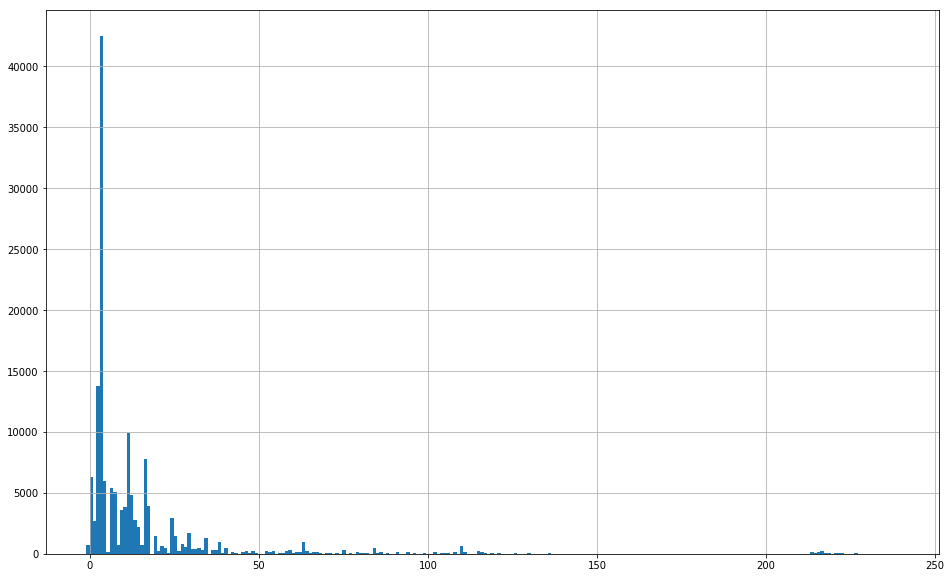

In [39]:
fig, ax = plt.subplots(figsize=(16, 10))
pd.Series(labels_dbScan).hist(bins = 241)

In [40]:
labels_dbScan.shape

(148518,)

In [41]:
(125974 + 22544)

148518